# Quantum Control as Polynomial Optimization: Piecewise constant controls 

This notebook uses multithreadin. Set  

    export JULIA_NUM_THREADS=100
   
before runing Julia

In [1]:
Threads.nthreads()

110

In [2]:
using LinearAlgebra
using DynamicPolynomials
using TSSOS
using JuMP
using Random
using NLopt
using SpecialFunctions
using HDF5

## Quantum system

In [3]:
#= 
Quantum system is taken from 
 https://github.com/q-optimize/c3/blob/master/examples/two_qubits.ipynb

Drift Hamiltonian
=#

H0 = [
    0 0 0;
    0 3.21505101e+10 0;
    0 0 6.23173079e+10
];

H0 ./= norm(H0, Inf)

# Control Hamiltonian
V = [
    0 1 0;
    1 0 1.41421356;
    0 1.41421356 0
]

V ./= norm(V, Inf);

## Chebyshve polynomial approximation for $\exp(\Delta t \Omega)$

In [4]:
"""
Chebyshev approximation for exp(Δt Ω)
"""
function exp_chebyshev(Δt::Real, Ω::AbstractMatrix, order::Integer)
    
    Tₙ₋₁ = I
    Tₙ  = Ω
    
    # The first two terms of Chebyshev series for exp
    series = besselj(0, Δt) * Tₙ₋₁ + 2 * besselj(1, Δt) * Tₙ
    
    for n=2:order
        Tₙ₊₁  = 2 * Ω * Tₙ + Tₙ₋₁
        
        series .+= 2 * besselj(n, Δt) * Tₙ₊₁
        
        (Tₙ, Tₙ₋₁) = (Tₙ₊₁, Tₙ) 
    end
    
    series
end

exp_chebyshev

In [5]:
@polyvar x[1:2]

# final time
const T = 0.5

Δt = T / size(x)[1]

𝓤 = prod(exp_chebyshev(Δt, -im * (H0 + ξ * V), 7) for ξ in x);

## Utilities

In [6]:
function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))# if ~isapproxzero(abs(c))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end

function propagate(x::AbstractArray)   
    #=
    Solve the equation of motion
    =#
    prod(exp(-im * Δt * (H0 + ξ * V)) for ξ in x)
end

function 𝓤_propagation(x::AbstractArray)   
    map(z -> z(x), 𝓤)
end

𝓤_propagation (generic function with 1 method)

## Read target unitiries

In [7]:
h5open("results.hdf5", "r") do fid
    global U_targets = read(fid["U_targets"])
    global magnus_norm_U_target_minus_obtained = read(fid["norm_U_target_minus_obtained"])
    global magnus_f_PSU = read(fid["f_PSU"]) 
end;

In [8]:
@time begin
    
n_samples = size(U_targets)[1]

# piecewise constant controls 
piecewise_const_x = zeros((n_samples, length(x)))
    
# Frobenius norm difference between target and obtained unitaries
norm_U_target_minus_obtained = zeros(n_samples)

# Difference between symbolic exponent and exact to check accuracy  
norm_𝓤_propagation_exact = zeros(n_samples)

# The normalised overlap of the evolution and the target 
f_PSU = zeros(n_samples) 
    
Threads.@threads for i=1:n_samples
    
    # target unitray
    U_target = U_targets[i, :, :]
        
    # get the polynomial objective function
    obj = square_frobenius_norm(
        U_target - 𝓤
    )
    
    # Get the global minimum via TSSOS library
    opt,sol,data = tssos_first(obj, variables(obj); QUIET = true, solution = true)
    
    previous_sol = sol
    previous_opt = opt
    
    while ~isnothing(sol)
        previous_sol = sol
        previous_opt = opt
            
        opt,sol,data = tssos_higher!(data; QUIET = true, solution = true)
    end

    min_x = previous_sol

    # saving the found controls
    piecewise_const_x[i, :] = min_x
        
    # Frobenius norm difference between target and obtained unitaries
    U_obtained = propagate(min_x)
    norm_U_target_minus_obtained[i] = norm(U_target - U_obtained)
        
    # The normalised overlap of the evolution and the target 
    f_PSU[i] = abs(tr(U_target' * U_obtained)) / size(U_obtained)[1]
        
    # Difference between symbolic exponent and exact to check accuracy 
    norm_𝓤_propagation_exact[i] = norm(U_obtained - 𝓤_propagation(min_x))   
end
    
end

************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************

optimum = 2.4250000485250232e-8
optimum = 1.4098462474340646e-7
optimum = 1.5987064362069517e-8
optimum = 3.825345412425554e-8
optimum = 2.790991291229593e-8
optimum = 8.356895773437762e-8
optimum = 4.222263788446933e-8
optimum = 7.112396357164519e-9
optimum = 1.6527489550591453e-7
optimum = 8.194852849317634e-9
optimum = 1.2140474547052353e-8
optimum = 1.467948930139514e-7
optimum = 1.1751242078759549e-8
optimum = 1.3734880684502673e-7
optimum = 4.847245412260017e-8
optimum = 3.7246845117889916e-8
optimum = 1.6784396141698564e-8
optimum = 8.521349804706677e-9
Global optimality certified!
Global optimality certified!
optimum = 2.1962607937143504e-7
Global optimality certified!
Global optimality certified!
optimum = 4.7132565243116045e-8
Global optimality certified!
optimum = 1.8472625998311877e-7
Global optimality certified!
optimum = 2.071780333993711e-8
Global optimality certified!
Global optimality certified!
optimum = 1.0120426823759283e-8
Global optimality certified!
Global optima

optimum = 1.0837864413789004e-7
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 8.094919705112783e-9
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
optimum = 1.3315107418501701e-8
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 6.652156278113308e-9
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 1.0777554282262775e-8
Global optimality certified!
************************TSSOS******

************************TSSOS************************
TSSOS is launching...
optimum = 5.7626767681818794e-9
optimum = 1.158353481408254e-8
Global optimality certified!
optimum = 1.1968454136705059e-8
Global optimality certified!
Global optimality certified!
optimum = 3.2272060250034304e-8
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 5.4637852071140704e-9
optimum = 1.0036326872956163e-8
optimum = 2.264142753449369e-7
optimum = 6.517085867980728e-8
optimum = 1.0427505683363746e-8
optimum = 8.099153440052745e-8
optimum = 3.35419689052287e-8
optimum = 6.281793514736157e-8
optimum = 6.338013402998167e-8
optimum = 1.599569081483722e-8
optimum = 1.0431655636107592e-8
optimum = 1.3824710541121208e-8
optimum = 9.633550417358598e-9
optimum = 9.826127167920564e-8
optimum = 8.452979477890549e-9
optimum = 2.527848009371728e-7
************************TSSOS************************
TSSOS is launching...
**

optimum = 7.737868502545249e-9
Global optimality certified!
optimum = 9.670303387628779e-8
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 1.377362751825275e-8
optimum = 2.8586549907659352e-8
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 5.631433587692005e-8
Global optimality certified!
Global optimality certified!
optimum = 1.0161541726500312e-8
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 1.5042295001477726e-8
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS******

No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.9855922023852283e-8
optimum = 1.8854625162122336e-8
No higher TSSOS hierarchy!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 8.879822571258419e-9
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 1.6474428380816173e-8
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
*********

optimum = 1.2879607597989236e-7
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 7.491362791949588e-9
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
optimum = 7.09810394454939e-8
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 1.0904077892429917e-8
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
optimum = 6.9781409170045735e-9
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
optimum = 2.6811984324696118e-8
optimum = 1.4657825164078423e-8
Global optimality cer

optimum = 9.324101785788847e-9
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 2.4005723176330724e-8
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
optimum = 1.1771696151360058e-8
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
optimum = 1.1118127269329681e-8
optimum = 8.465777360350612e-9
Global optimality certified!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 8.58688915009779e-9
optimum = 4.555793101755741e-8
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
**********

optimum = 4.544050723663691e-8
No higher TSSOS hierarchy!
Global optimality certified!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
optimum = 8.805826097095192e-9
No higher TSSOS hierarchy!
optimum = 2.07768191741209e-8
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 4.5069078262140236e-8
optimum = 7.727340438785848e-9
No higher TSSOS hierarchy!
Global optimality certified!
optimum = 9.953294433394462e-9
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
Global optimality certified!
************************TSSOS***********

optimum = 9.412679233086025e-9
No higher TSSOS hierarchy!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 4.6161794557425786e-8
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 4.509008866994417e-8
************************TSSOS************************
TSSOS is launching...
optimum = 7.84484182425119e-8
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
optimum = 1.0678606434537025e-8
optim

Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 8.048402883472947e-8
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 6.939915270697027e-8
optimum = 9.3689013432997e-9
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 8.12381363756801e-9
optimum = 7.399946334749262e-9
Global optimality certified!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 9.766844570048606e-9
Global optimality certified!
optimum = 9.689766243989464e-9
Global optimality certified!
************************TSSOS**********

************************TSSOS************************
TSSOS is launching...
optimum = 8.441985846872408e-8
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
optimum = 7.214539414612909e-9
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 8.996921704010439e-9
optimum = 1.032346926413784e-8
optimum = 1.0982136902712396e-8
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 8.383409676967685e-8
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 3.387660856105058e-8
Global optimality certified!
optimum = 4.940239913378984e-8
Global optimality certified!
************************TSSOS**********************

## Save results

In [9]:
h5open("results_PiecewiseConst.hdf5", "w") do fid
    fid["U_targets"] = U_targets
    fid["piecewise_const_x"] = piecewise_const_x
    fid["f_PSU"] = f_PSU
    fid["norm_U_target_minus_obtained"] = norm_U_target_minus_obtained
end;

## Analysis

In [10]:
using PyPlot

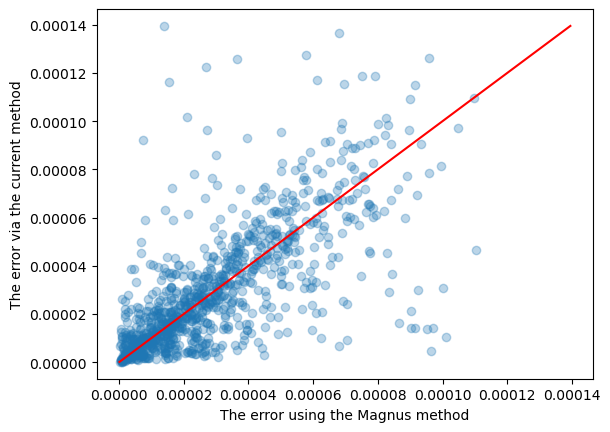

In [19]:
scatter(magnus_norm_U_target_minus_obtained, norm_U_target_minus_obtained, alpha=0.3)

lower = min(minimum(magnus_norm_U_target_minus_obtained), minimum(norm_U_target_minus_obtained))
higher = max(maximum(magnus_norm_U_target_minus_obtained), maximum(norm_U_target_minus_obtained))
plot([lower, higher], [lower, higher], "r")

xlabel("The error using the Magnus method")
ylabel("The error via the current method")
show()

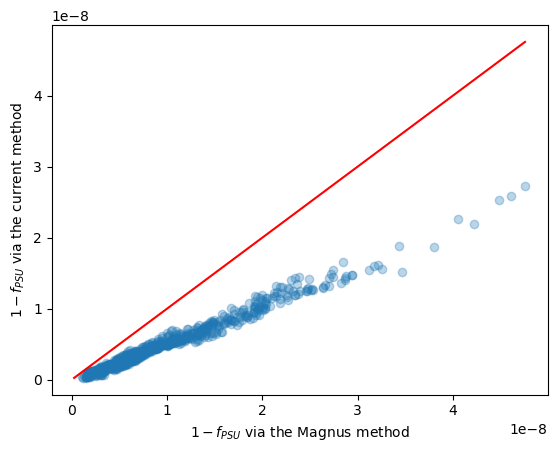

In [20]:
magnus_ε = 1 .- magnus_f_PSU
ε = 1 .- f_PSU

scatter(magnus_ε, ε,  alpha=0.3)

lower = min(minimum(magnus_ε), minimum(ε))
higher = max(maximum(magnus_ε), maximum(ε))
plot([lower, higher], [lower, higher], "r")

xlabel(L"1 - f_{PSU}" * " via the Magnus method")
ylabel(L"1 - f_{PSU}" * " via the current method")
show()